In [1]:
struct Global
    nv          ::Int    #boundary point
    jx          ::Int    #cell number
    #nm          ::Int    #N of matter
    kindProblem ::Int #kind of problem
    tt          ::Float64      #total time
    cfl         ::Float64     # cfl
end

struct Const
    Y0 ::Float64
    ρ0 ::Float64
    Γ0 ::Float64
    μ  ::Float64
    a0 ::Float64
    s0 ::Float64
end
    

struct BoundCon
    ρ ::Float64
    u ::Float64
    p ::Float64
    sxx::Float64
end


$$ 1Pa = 1N/m^2 = 1 kg/(m\cdot s^2) = 10^{-11} g/(cm \cdot \mu s^2)$$ 

$$ 1 m/s = 10^{-4} cm/\mu s$$
$$ 1kg/m^3 = 10^{-3} g/cm^3$$


$$f(\eta) = \frac{(\eta-1)(\eta-\Gamma_0(\eta-1)/2)}{(\eta-s_0(\eta-1))^2}$$
$$f'(\eta) = \frac{\eta+(s_0-\Gamma_0)(\eta-1)}{(\eta-s_0(\eta-1))^3}$$

In [2]:

function fη(ρ::Float64,c::Const)
    η = ρ/c.ρ0
    fη=(η-1.0)*(η-c.Γ0*(η-1.0)/2.0)/(η-c.s0*(η-1))^2
end

function fηη(ρ::Float64,c::Const)
    η = ρ/c.ρ0
    fηη=(η+(c.s0-c.Γ0)*(η-1))/(η-c.s0*(η-1))^3
end


fηη (generic function with 1 method)

Mie-Gr\"uneisen equation of state
$$e =\frac{p-\rho_0a_0^2f(\eta)}{\rho_0\Gamma_0}$$

$$p = \rho_0a_0^2f(\eta)+\rho_0\Gamma_0e$$

In [3]:
function PToe(ρ::Float64,p::Float64,con::Const)
    c=con
    ei = (p-c.ρ0*c.a0^2*fη(ρ,c))/(c.ρ0*c.Γ0)
    return ei
end
function EToP(ρ::Float64,ei::Float64,con::Const)
    c=con
    p = c.ρ0*c.Γ0*ei+c.ρ0*c.a0^2*fη(ρ,c)
    return p
end

EToP (generic function with 1 method)

$$ \begin{aligned}
    & \rho = uo[1]\\
    & u  = uo[2]\\
    & p =uo[3]\\
    & s_{xx}=uo[4]
     \end{aligned} \hspace{0.3cm}
    \begin{aligned}
    &U[1]=\rho\\
    &U[2]=\rho u\\
    &U[3]=\rho E\\
    &U[4]=s_{xx}\\
    \end{aligned}
$$

$$ e=E/\rho-\frac{1}{2}u^2$$


In [4]:
"""
 from  the primitive variables uo to  conservative variables U
"""
function UoTou(uo::Array{Float64,1},con::Const)
    u = zeros(Float64, 4)
    u[1]=uo[1]
    u[2]=uo[2]*uo[1]
    ei = PToe(uo[1],uo[3],con)
    u[3]=(ei+0.5uo[2]^2)*uo[1]
    u[4]=uo[4]
    return u
end

UoTou

In [5]:
"""
 from conservative variables U  to  the primitive variables uo
"""
function UToUo(u::Array{Float64,1},con::Const)
    uo = zeros(Float64, 4)
    uo[1]=u[1]
    uo[2]=u[2]/u[1]
    ei=u[3]/uo[1]-0.5uo[2]^2
    p = EToP(uo[1],ei,con)
    uo[3]=p
    uo[4]=u[4]
    return uo
end  

UToUo

$$ c=\sqrt{a^2-\frac{\rho_0}{\rho^2}\Gamma_0s_{xx}+\frac{4}{3}\frac{\mu}{\rho}}$$
$$ a^2= a_0^2 f'(\eta)+\frac{p}{\rho^2}\rho_0\Gamma_0$$

In [6]:
function sound(uo::Array{Float64,1},con::Const)
    a0  = con.a0
    ρ0  = con.ρ0
    Γ0  = con.Γ0
    μ   = con.μ
    ρ   = uo[1]
    uu  = uo[2]
    p   = uo[3]
    sxx = uo[4]
    a2  = a0^2*fηη(ρ,con)+p/ρ^2*ρ0*Γ0
    c = ftest(a2,ρ0,ρ,Γ0,sxx,μ,a0,fηη(ρ,con),p)
    
  #  c=sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
    
    return c
end




sound (generic function with 1 method)

In [7]:
ftest(a2,ρ0,ρ,Γ0,sxx,μ,a0,f,p)=try
        sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
    catch
        println("a2= ",a2,"ρ0 = ", ρ0,"ρ = ",
            ρ, "Γ0= ",Γ0,"Sxx = ", sxx,μ, "a0 = ", 
            a0, "f = ",f, "p = ", p)
    end



ftest (generic function with 1 method)

In [8]:
function Cfl(uo::Array{Float64,2},x::Array{Float64,1},
        inter::Array{Int,1},problem::Global=problem )
    nv=problem.nv
    jx=problem.jx
    sf=problem.cfl
    
   dx1=0
   dxmin=x[nv+2]-x[nv+1]
    for i in nv+2:jx+nv+1
        dx  = x[i]-x[i-1]
        if inter[i] == 1
            c = sound(uo[i,:],con1)
        else
            c = sound(uo[i,:],con2)
        end
        dxmin = min(dx,dxmin)
        dx1=dxmin/c
    end
   dt=sf*dx1
   return dt
end    

Cfl (generic function with 2 methods)

In [9]:
function WENO3(u::Array{Float64,1})
    ε = 1.e-10
    I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-1
        IS0 = (u[i] - u[i-1])^2
        IS1 = (u[i+1] - u[i])^2
        
        c0 = 2/3
        c1 = 1/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        β0 = α0/(α0+α1)
        β1 = α1/(α0+α1)
        
        uR[i-1] = β0*(u[i]+u[i-1])/2+β1*(3u[i]-u[i+1])/2
        
        c0 = 1/3
        c1 = 2/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        β0 = α0/(α0+α1)
        β1 = α1/(α0+α1)
        
        uL[i] = β0*(3u[i]-u[i-1])/2+β1*(u[i]+u[i+1])/2
    end
    return uL,uR
end
        

WENO3 (generic function with 1 method)

In [10]:
function Upwind(u::Array{Float64,1})
     I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-1
        uL[i] = u[i]
        uR[i] = u[i+1]
    end
    return uL,uR
end


Upwind (generic function with 1 method)

In [11]:
function Yυ(s::Float64,con::Const=con)
    Y0 = con.Y0
    f=0
    if abs(s) <= 2Y0/3
        f = s
    elseif s > 2Y0/3
        f = 2Y0/3
    else
        f = -2Y0/3
    end
end

Yυ (generic function with 2 methods)

$$s^* = \frac{\sigma_L -\sigma_R+\rho_L u_L(s_L-u_L)}$$

In [102]:
function HLLCEPNew(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        inter::Array{Int,1},problem::Global=problem)

    nv = problem.nv
    jx = problem.nv
   
    I,J = size(uL)
    f  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    ue = zeros(Float64,I)
    
    for i in 1:I
           if inter[i] == 1 
            conL = con1
            conR = con1
            Y0L = con1.Y0
            ρ0L = con1.ρ0
            Γ0L = con1.Γ0
            a0L = con1.a0
            μL  = con1.μ

            Y0R = con1.Y0
            ρ0R = con1.ρ0
            Γ0R = con1.Γ0
            a0R = con1.a0
            μR  = con1.μ
        else
            conL = con2
            conR = con2
            Y0L = con2.Y0
            ρ0L = con2.ρ0
            Γ0L = con2.Γ0
            a0L = con2.a0
            μL  = con2.μ

            Y0R = con2.Y0
            ρ0R = con2.ρ0
            Γ0R = con2.Γ0
            a0R = con2.a0
            μR  = con2.μ
             
        end
#         if inter[i]==1 && inter[i+1] == 2
#             conL = con1
#             conR = con2
#             μL  = con1.μ
#             μR  = con2.μ
#         end
       
        
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:],conL)
        eL = PToe(ρL, pL, conL)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:],conR)
        eR = PToe(ρR, pR, conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4.0μL/3*log(ρLstar/ρL) +sxxL
        if (abs(sxxL) < 2Y0L/3 && abs(tmp) >= 2Y0L/3)

       # if abs(tmp) >= 2Y0/3 
            if tmp > 2Y0L/3
                hsxxL = 2Y0L/3
                hρL  = ρL*exp(-Y0L/(2μL)+3sxxL/(4μL))
            elseif tmp < -2/3*Y0L
                hsxxL = -2Y0L/3
                hρL  = ρL*exp(Y0L/(2μL)+3sxxL/(4μL))
            end
            t    = 1/ρL-1/hρL
            c0   = 1/(ρ0L*Γ0L)
            c1   = a0L^2/Γ0L
            hpL   = (2(c1*fη(hρL,conL)+eL)-t*(σL+hsxxL))/(2c0-t)
            hσL = -hpL + hsxxL
            if ρLstar > ρL
               huuL = uuL -sqrt((σL-hσL)*t)
            else
               huuL = uuL +sqrt((σL-hσL)*t)
            end
            ρL   = hρL
            uuL  = huuL
            pL   = hpL
            sxxL = hsxxL
            σL   = hσL
            ue[1] = ρL
            ue[2] = uuL
            ue[3] = pL
            ue[4] = sxxL
            cL = sound(ue,conL)
        end
        
        tmp = -4.0μR/3*log(ρRstar/ρR) +sxxR
        if abs(sxxR) < 2Y0R/3 && abs(tmp) >= 2Y0R/3 
        #if abs(tmp) >= 2Y0/3
            if tmp > 2Y0R/3
               hsxxR = 2Y0R/3
               hρR  = ρR*exp(-Y0R/(2μR)+3sxxR/(4μR))
            elseif tmp < -2/3*Y0R
               hsxxR = -2Y0R/3
               hρR  = ρR*exp(Y0R/(2μR)+3sxxR/(4μR))
            end
            t    = 1/ρR-1/hρR
            c0   = 1/(ρ0R*Γ0R)
            c1   = a0R^2/Γ0R
           hpR   = (2(c1*fη(hρR,conR)+eR)-t*(σR+hsxxR))/(2c0-t)
           hσR = -hpR +hsxxR
            if ρRstar > ρR
               huuR = uuR +sqrt((σR-hσR)*t)
            else
               huuR = uuR -sqrt((σR-hσR)*t)
            end
            ρR = hρR
            uuR = huuR
            pR = hpR
            sxxR = hsxxR
            σR = hσR
            ue[1] = ρR
            ue[2] = uuR
            ue[3] = pR
            ue[4] = sxxR
            cR = sound(ue,conR)
        end
        sL = min(uuL-cL,uuR-cR)
        sR = max(uuL+cL,uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4μL/3*log(ρLstar/ρL) +sxxL
        if tmp >= 2Y0L/3
            sxxLstar = 2Y0L/3
        elseif tmp <= -2Y0L/3
            sxxLstar  = -2Y0L/3
        else
            sxxLstar = tmp
        end
        
        tmp = -4μR/3*log(ρRstar/ρR) +sxxR
        
        if tmp >= 2Y0R/3
            sxxRstar = 2Y0R/3
        elseif tmp <= -2Y0R/3
            sxxRstar  = -2Y0R/3
        else
            sxxRstar = tmp
        end
        
        σstar = σL-ρL*(sL-uuL)*(s_star-uuL)
        pLstar = sxxLstar-σstar
        pRstar = sxxRstar-σstar
        
        if s_star > u[i] 
            f[i,1] = 0
            f[i,2] = pLstar-sxxLstar
            f[i,3] = (pLstar-sxxLstar)*s_star
            f[i,4] = -4μL/3*s_star
            uuh[i] = s_star
        else
            f[i,1] = 0
            f[i,2] = pRstar-sxxRstar
            f[i,3] = (pRstar-sxxRstar)*s_star
            f[i,4] = -4μR/3*s_star
            uuh[i] = s_star
        end
    end
    return f, uuh
end

HLLCEPNew (generic function with 2 methods)

In [83]:
function HLLCEP(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        inter::Array{Int,1},problem::Global=problem)
   
    nv = problem.nv
    jx = problem.jx
    I,J = size(uL)
    f  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    
    for i in 1:I
        if inter[i] == 1 
            conL = con1
            conR = con1
            μL  = con1.μ
            μR  = con1.μ
        else
             conL = con2
            conR = con2
            μL  = con2.μ
            μR  = con2.μ
        end
#         if inter[i]==1 && inter[i+1] == 2
#             conL = con1
#             conR = con2
#             μL  = con1.μ
#             μR  = con2.μ
#         end
        
        
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:],conL)
        eL = PToe(ρL, pL, conL)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:],conR)
        eR = PToe(ρR, pR, conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        s_barstar = (sxxR-sxxL)/(ρL*(sL-uuL)-ρR*(sR-uuR))
        sxxL_bar = sxxL+ρL*(sL-uuL)*s_barstar
        sxxR_bar = sxxR+ρR*(sR-uuR)*s_barstar
        
        sxxL_star = Yυ(sxxL_bar,conL)
        sxxR_star = Yυ(sxxR_bar,conR)
        
        sxL_star = (sxxL_star-sxxL)/(ρL*(sL-uuL))
        sxR_star = (sxxR_star-sxxR)/(ρR*(sR-uuR))
        
        
        s_star = (pR - pL + ρL*(uuL-sxL_star)*(sL-uuL) - ρR* (uuR-sxR_star)*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        pL_star = pL+ρL*(sL-uuL)*(s_star + sxL_star - uuL)
        pR_star = pR+ρR*(sR-uuR)*(s_star + sxR_star - uuR)
        
        if s_star > u[i]
            f[i,1] = 0
            f[i,2] = pL_star-sxxL_star
            f[i,3] = (pL_star-sxxL_star)*s_star
            f[i,4] = -4μL/3*s_star 
            uuh[i] = s_star
        else
            f[i,1] = 0
            f[i,2] = pR_star-sxxR_star
            f[i,3] = (pR_star-sxxR_star)*s_star
            f[i,4] = -4μR/3*s_star 
            uuh[i] = s_star
        end
    end
    
          
    return f, uuh
end
        

HLLCEP (generic function with 2 methods)

In [118]:
function Space(uo::Array{Float64,2},inter::Array{Int,1},problem::Global=problem)
    kind_split = 1
    nv = problem.nv
    h = zeros(Float64,2)
   
    I,J = size(uo)
    uL=zeros(Float64,(I,J))
    uR=zeros(Float64,(I,J))
    f=zeros(Float64,(I,J))
    uuh=zeros(Float64,I)
     if kind_split==1
        for i in 1:J
            uL[:,i],uR[:,i] = WENO3(uo[:,i])
           # uL[:,i],uR[:,i] = Upwind(uo[:,i])
        end
        h,uuh = HLLCEP(uo[:,2],uL,uR,inter)
     #   h,uuh = HLLCEPNew(uo[:,2],uL,uR,inter)
     end
    for i in 2:I-1
        f[i,:]= h[i,:]-h[i-1,:]
    end
    return f,uuh
end
        

Space (generic function with 2 methods)

In [67]:
function Bound!(uo::Array{Float64,2},u::Array{Float64,2},inter::Array{Int,1},lB::BoundCon=lB,
                rB::BoundCon=rB, problem::Global=problem)
    kind_prb= problem.kindProblem
    nv = problem.nv
    jx = problem.jx
    uu = lB.u
    ρ  = lB.ρ
        ue = zeros(Float64,4)
        for i in 1:nv
            uo[i,:] = uo[nv+1,:]
        
            
#             ue[1] = ρ
#             ue[2] = u[nv+1,2]/u[nv+1,1]
#             ue[3] = 0
#             ue[4] = 0
            
           # u[i,:] = UoTou(ue,con1)
        u[i,:] = u[nv+1,:]
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            uo[i+jx+nv+1,2] = -uo[jx+nv+1-i,2]
            u[i+jx+nv+1,:] = u[jx+nv+1-i,:]
        end 

    return uo,u
end

Bound! (generic function with 4 methods)

In [68]:
function R_K3(dt::Float64,uo::Array{Float64,2},x::Array{Float64,1},inter::Array{Int,1},
        lB::BoundCon=lB,rB::BoundCon=rB,problem::Global=problem)
    I,J=size(uo)
    dx = zeros(Float64,I)
    udx= zeros(Float64,(I,J))
    u= zeros(Float64,(I,J))
    for i in 2:I
        dx[i] =x[i]-x[i-1]
    end
    dx[1] =dx[2]
    
    for i in 1:I
        if  inter[i] == 1
            u[i,1:4]=UoTou(uo[i,1:4],con1)
        else
            u[i,1:4]=UoTou(uo[i,1:4],con2)
        end
        udx[i,1:3]=u[i,1:3]*dx[i]
        udx[i,4] =u[i,4]
    end 
    
    uo,u = Bound!(uo,u,inter)
#****************1**********************    
    f,uuh=Space(uo,inter)   
    #x1 = zeros(Float64,I) 
    
    udx1 = zeros(Float64,(I,J))
    x1   = zeros(Float64,I)
    for i in 1:I
        x1[i] = x[i] + dt*uuh[i]
        udx1[i,4] = udx[i,4] -dt*f[i,4]/dx[i]
    end
    
    for i in 2:I
        dx[i] =x1[i]-x1[i-1]
    end
    dx[1] =dx[2]
    for i in 1:I
        ρ1 = u[i,1]
        udx1[i,1:3] = udx[i,1:3] -dt*f[i,1:3]
        u[i,1:3] = udx1[i,1:3]/dx[i]
        u[i,4]=  udx1[i,4]
        if  inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
             u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
    end
    
    uo,u = Bound!(uo,u,inter)
# #***************2***********************    
    
    f,uuh = Space(uo,inter)
    
    udx2 = zeros(Float64,(I,J))
    x2   = zeros(Float64,I)
   
    for i in 1:I
        x2[i] = 3/4*x[i] +1/4*x1[i]+1/4*dt*uuh[i]
        udx2[i,4] = 3/4*udx[i,4]+1/4*udx1[i,4] -1/4*dt*f[i,4]/dx[i]
    end
   
    for i in 2:I
        dx[i] =x2[i]-x2[i-1]
    end
    dx[1] =dx[2]
    
    for i in 1:I
        udx2[i,1:3] = 3/4*udx[i,1:3]+1/4*udx1[i,1:3] -1/4*dt*f[i,1:3]
        u[i,1:3] = udx2[i,1:3]/dx[i]
        u[i,4]   = udx2[i,4]
        if inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
            u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
        
    end    
    uo,u = Bound!(uo,u,inter)
  #***************3**********************   
    f,uuh = Space(uo,inter)
  
   for i in 1:I
       x[i] = 1/3*x[i] +2/3*x2[i]+2/3*dt*uuh[i]
        udx[i,4] = 1/3*udx[i,4]+2/3*udx2[i,4] -2/3*dt*f[i,4]/dx[i]
    end
    for i in 2:I
        dx[i] = x[i]-x[i-1]
    end
    dx[1] =dx[2]
    
    
    for i in 1:I
        udx[i,1:3] = 1/3*udx[i,1:3]+2/3*udx2[i,1:3] -2/3*dt*f[i,1:3]
        u[i,1:3] = udx[i,1:3]/dx[i]
        u[i,4]=udx[i,4]
        if inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
            u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
     end
    uo,u = Bound!(uo,u,inter)
    
    return uo,x
end    
    
    

R_K3 (generic function with 4 methods)

In [69]:
function TimeSolve(uo::Array{Float64,2},x::Array{Float64,1},inter::Array{Int,1})
#    uo,u,x=initial()
    tt= problem.tt
    
    t=0 
    it =1
    
   # plt = Plots.plot() 
    while t<tt
   # for i in 1:4
        dt=Cfl(uo,x,inter)
        if t+dt>tt
           dt = tt-t
        end
        t += dt
        uo,x=R_K3(dt,uo,x,inter)
        #if t/(tt/10) > it
        #    it += 1
            println(dt,"  ", t)
         #  plot(x,uo[:,1])
        #end
    end
    
    return uo,x
end

TimeSolve (generic function with 1 method)

In [70]:
function TwoMatter()
    
    nv = 3
    jx = 800
    tt = 2.0
    cfl = 0.5
    lx =5.0
  
    kindProblem=1
    dx=lx/jx


    ρ2=2.785
    u2=0.0
    p2=1.e-12
    sxx2=0.0
    
    
    ρ1=8.93
    u1=0.09
    p1=1.e-12
    sxx1=0.0
    
    global    rB=BoundCon(ρ2,u2,p2,sxx2)
    global    lB=BoundCon(ρ1,u1,p1,sxx1)
    
    global   con2 = Const(3e-3,2.785,2.0,2.76e-1,0.5328,1.338)  #copper
    
    global   con1 = Const(9e-4,8.93,2.0,4.5e-1,3.94,1.49)  #

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]
    
    ii = floor(Int,2.5/dx)
    
    for i=1:jx+2nv+1
        if i <= ii
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con1)
        else
            inter[i] =2
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con2)
        end
        if i <= ii
            inter[i] = 1
        else
            inter[i] = 2
        end
        
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

TwoMatter (generic function with 1 method)

In [108]:
function TwoMatter1()
    
    nv = 3
    jx = 800
    tt = 2.0e-6
    cfl = 0.5
    lx =5.0e-2
  
    kindProblem=1
    dx=lx/jx


    ρ2=2785
    u2=0.0
    p2=1.e-12
    sxx2=0.0
    
    
    ρ1=8930
    u1=50
    p1=1.e-12
    sxx1=0.0
    
    global    rB=BoundCon(ρ2,u2,p2,sxx2)
    global    lB=BoundCon(ρ1,u1,p1,sxx1)
    
    global   con2 = Const(3e8,2785,2.0,2.76e10,5328,1.338)  #copper
    
    global   con1 = Const(9e7,8930,2.0,4.5e10,3940,1.49)  #

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]
    
    ii = floor(Int,2.5e-2/dx)
    
    for i=1:jx+2nv+1
        if i <= ii
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con1)
        else
            inter[i] =2
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con2)
        end
        if i <= ii
            inter[i] = 1
        else
            inter[i] = 2
        end
        
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

TwoMatter1 (generic function with 1 method)

In [119]:
using Plots
uo,u,x,inter = TwoMatter1()
plot(x,uo[:,1])
plot!(x,inter)
uo,x = TimeSolve(uo,x,inter)
#uo

4.845035279033152e-9  4.845035279033152e-9
4.83353917909721e-9  9.678574458130363e-9
4.826956383257701e-9  1.4505530841388063e-8
4.823254131107718e-9  1.9328784972495783e-8
4.8212425666258615e-9  2.4150027539121644e-8
4.820145399067789e-9  2.8970172938189435e-8
4.819694819511503e-9  3.3789867757700936e-8
4.819761000695167e-9  3.8609628758396104e-8
4.8199907974360386e-9  4.3429619555832146e-8
4.819426380844806e-9  4.8249045936676954e-8
4.818896262888468e-9  5.306794219956542e-8
4.8187401763965715e-9  5.788668237596199e-8
4.81883910820196e-9  6.270552148416396e-8
4.819055461527673e-9  6.752457694569163e-8
4.81931245252372e-9  7.234388939821534e-8
4.819414703822962e-9  7.71633041020383e-8
4.819321988903186e-9  8.198262609094149e-8
4.819314351041049e-9  8.680194044198254e-8
4.819335817253434e-9  9.162127625923597e-8
4.819481577860651e-9  9.644075783709663e-8
4.8195991524604354e-9  1.0126035698955707e-7
4.8194515190935305e-9  1.060798085086506e-7
4.8194123264799e-9  1.108992208351305e-7
4.8

4.819866194395439e-9  1.0073877302535894e-6
4.819866191344431e-9  1.012207596444934e-6
4.819866177766314e-9  1.0170274626227003e-6
4.819866163129328e-9  1.0218473287858296e-6
4.819866156595641e-9  1.0266671949424252e-6
4.819866151744258e-9  1.0314870610941695e-6
4.819866145415782e-9  1.0363069272395854e-6
4.819866127728594e-9  1.041126793367314e-6
4.819866121136813e-9  1.0459466594884506e-6
4.819866115603363e-9  1.050766525604054e-6
4.819866116743726e-9  1.0555863917207977e-6
4.819866099283265e-9  1.060406257820081e-6
4.819866093726417e-9  1.0652261239138073e-6
4.81986608680194e-9  1.0700459900006093e-6
4.8198660824314454e-9  1.0748658560830407e-6
4.819866062309422e-9  1.0796857221453501e-6
4.819866056901574e-9  1.0845055882022517e-6
4.819866048419856e-9  1.0893254542506715e-6
4.819866050062893e-9  1.0941453203007343e-6
4.819866039607326e-9  1.0989651863403416e-6
4.819866030877365e-9  1.1037850523712189e-6
4.819866025528149e-9  1.108604918396747e-6
4.819866023180723e-9  1.1134247844199

4.8198648015617156e-9  1.9087025746303995e-6
4.819864795748555e-9  1.913522439426148e-6
4.819864790066643e-9  1.9183423042162145e-6
4.819864784326907e-9  1.9231621690005416e-6
4.819864778636927e-9  1.9279820337791784e-6
4.819864773078196e-9  1.9328018985522564e-6
4.819864767475627e-9  1.9376217633197322e-6
4.819864761912861e-9  1.942441628081645e-6
4.819864756481346e-9  1.9472614928381264e-6
4.8198647509938875e-9  1.9520813575891202e-6
4.819864745555379e-9  1.9569012223346757e-6
4.8198647402430095e-9  1.9617210870749185e-6
4.819864734871471e-9  1.96654095180979e-6
4.819864729552109e-9  1.971360816539342e-6
4.8198647243513545e-9  1.976180681263693e-6
4.819864719083901e-9  1.981000545982777e-6
4.819864713874272e-9  1.9858204106966514e-6
4.819864708773569e-9  1.990640275405425e-6
4.819864703624186e-9  1.995460140109049e-6
4.539859890950736e-9  2.0e-6


([8930.0 50.0 0.0032944 0.000166241; 8930.0 50.0 0.0032944 0.000166241; … ; 2785.0 3.30301e-13 -0.0175547 -0.0175571; 2785.0 5.40859e-13 0.00877736 0.0087771], [NaN, -2.5e-5, 3.75e-5, 0.0001, 0.0001625, 0.000225, 0.0002875, 0.00035, 0.0004125, 0.000475  …  0.049625, 0.0496875, 0.04975, 0.0498125, 0.049875, 0.0499375, 0.05, 0.0500625, NaN, NaN])

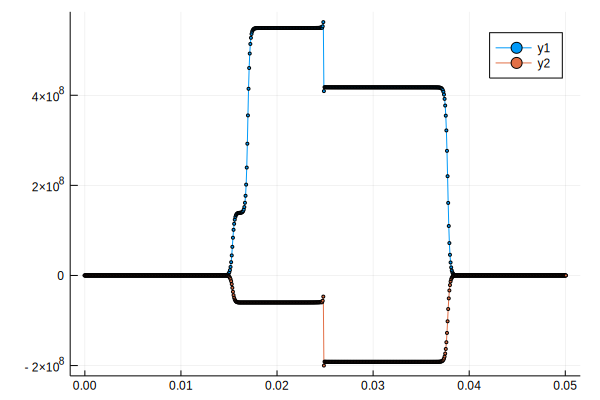

In [117]:
using Plots
plot(x,uo[:,3:4],marker=2)

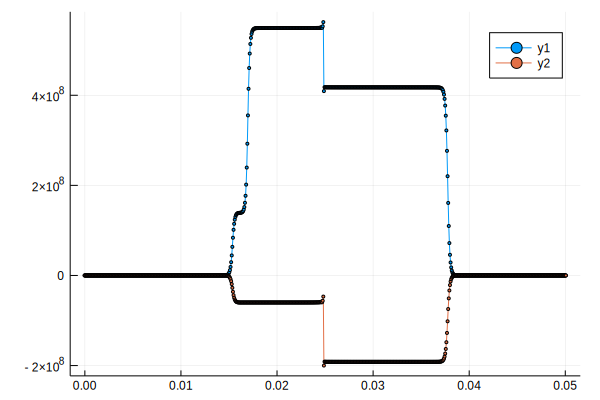

In [120]:
plot(x,uo[:,3:4],marker=2)

In [53]:
? plot

search: plot plot! plotly plot3d Plots plot3d! plotlyjs plotattr plotarea



The main plot command. Use `plot` to create a new plot object, and `plot!` to add to an existing one:

```
    plot(args...; kw...)                  # creates a new plot window, and sets it to be the current
    plot!(args...; kw...)                 # adds to the `current`
    plot!(plotobj, args...; kw...)        # adds to the plot `plotobj`
```

There are lots of ways to pass in data, and lots of keyword arguments... just try it and it will likely work as expected. When you pass in matrices, it splits by columns. To see the list of available attributes, use the `plotattr([attr])` function, where `attr` is the symbol `:Series:`, `:Subplot:`, `:Plot` or `:Axis`. Pass any attribute to `plotattr` as a String to look up its docstring; e.g. `plotattr("seriestype")`.


In [121]:
:ls

:ls

In [122]:
$ls

LoadError: syntax: "$" expression outside quote

In [123]:
? ls

search: task_local_storage lstat lstrip else elseif falses ifelse last less LMS

Couldn't find ls
Perhaps you meant lB, else, less, last, lcm, log, let, all, cld, fld, In or Yυ


No documentation found.

Binding `ls` does not exist.
